# Fraud Detection Prediction
<font color="gray">
<br><b>Index: </b><br>
1.About the dataset <br>
2.Data Cleaning <br>
3.Exploratory Data Analysis<br>
4.Modeling: <i>choosing model, fitting, training</i><br>
5.Conclusion<br>

 ### 1. About the dataset

Dataset belongs to Kaggle and can be accessed at:
https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

Explanation about the labels weren't clear in the documentation above. <br>
It seems this dataset was artificially created¹ through another Kaggle dataset². <br>
<br>
<b>Label Description </b> 
<br>
<b>step</b> - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation). <br>
<b>type</b> - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. <br>
<b>amount</b> - amount of the transaction in local currency. <br>
<b>nameOrig</b> - customer who started the transaction <br>
<b>oldbalanceOrg</b> - initial balance before the transaction <br> 
<b>newbalanceOrig</b> - new balance after the transaction <br>
<b>nameDest</b> - customer who is the recipient of the transaction <br>
<b>oldbalanceDest</b> - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants). <br>
<b>newbalanceDest</b> - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants). <br>
<b>isFraud</b> - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. <br>
    <b>isFlaggedFraud</b> - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction. <br>
    
¹ https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION <br>
² https://www.kaggle.com/datasets/vardhansiramdasu/fraudulent-transactions-prediction/data


In [34]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv('/Users/tamirisnaganooliveira/Documents/Data_science_projects/fraud_detection/PS_20174392719_1491204439457_log.csv')
df.head(4)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0


## 2.Data Cleaning

<b>1.</b> checking data type<br>
<b>2.</b> Null or missing values<br>
<b>3.</b> outliers<br>
<b>4.</b> Validating features according to the documentation<br>

<b>1. Checking data type

In [38]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

<font color="steelblue">No abnormal type, so no changes here.</font>

<b>2. NULLS and missing values</b>

In [41]:
print(df.isnull().any())
# df.isna().sum()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool


**3. Outliers**

In [43]:
df.describe().astype(int)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
mean,243,179861,833883,855113,1100701,1224996,0,0
std,142,603858,2888242,2924048,3399180,3674128,0,0
min,1,0,0,0,0,0,0,0
25%,156,13389,0,0,0,0,0,0
50%,239,74871,14208,0,132705,214661,0,0
75%,335,208721,107315,144258,943036,1111909,0,0
max,743,92445516,59585040,49585040,356015889,356179278,1,1


/var/folders/wp/d442_yjd3r7bs1s744_n3s6r0000gn/T/ipykernel_39439/2447770335.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax)


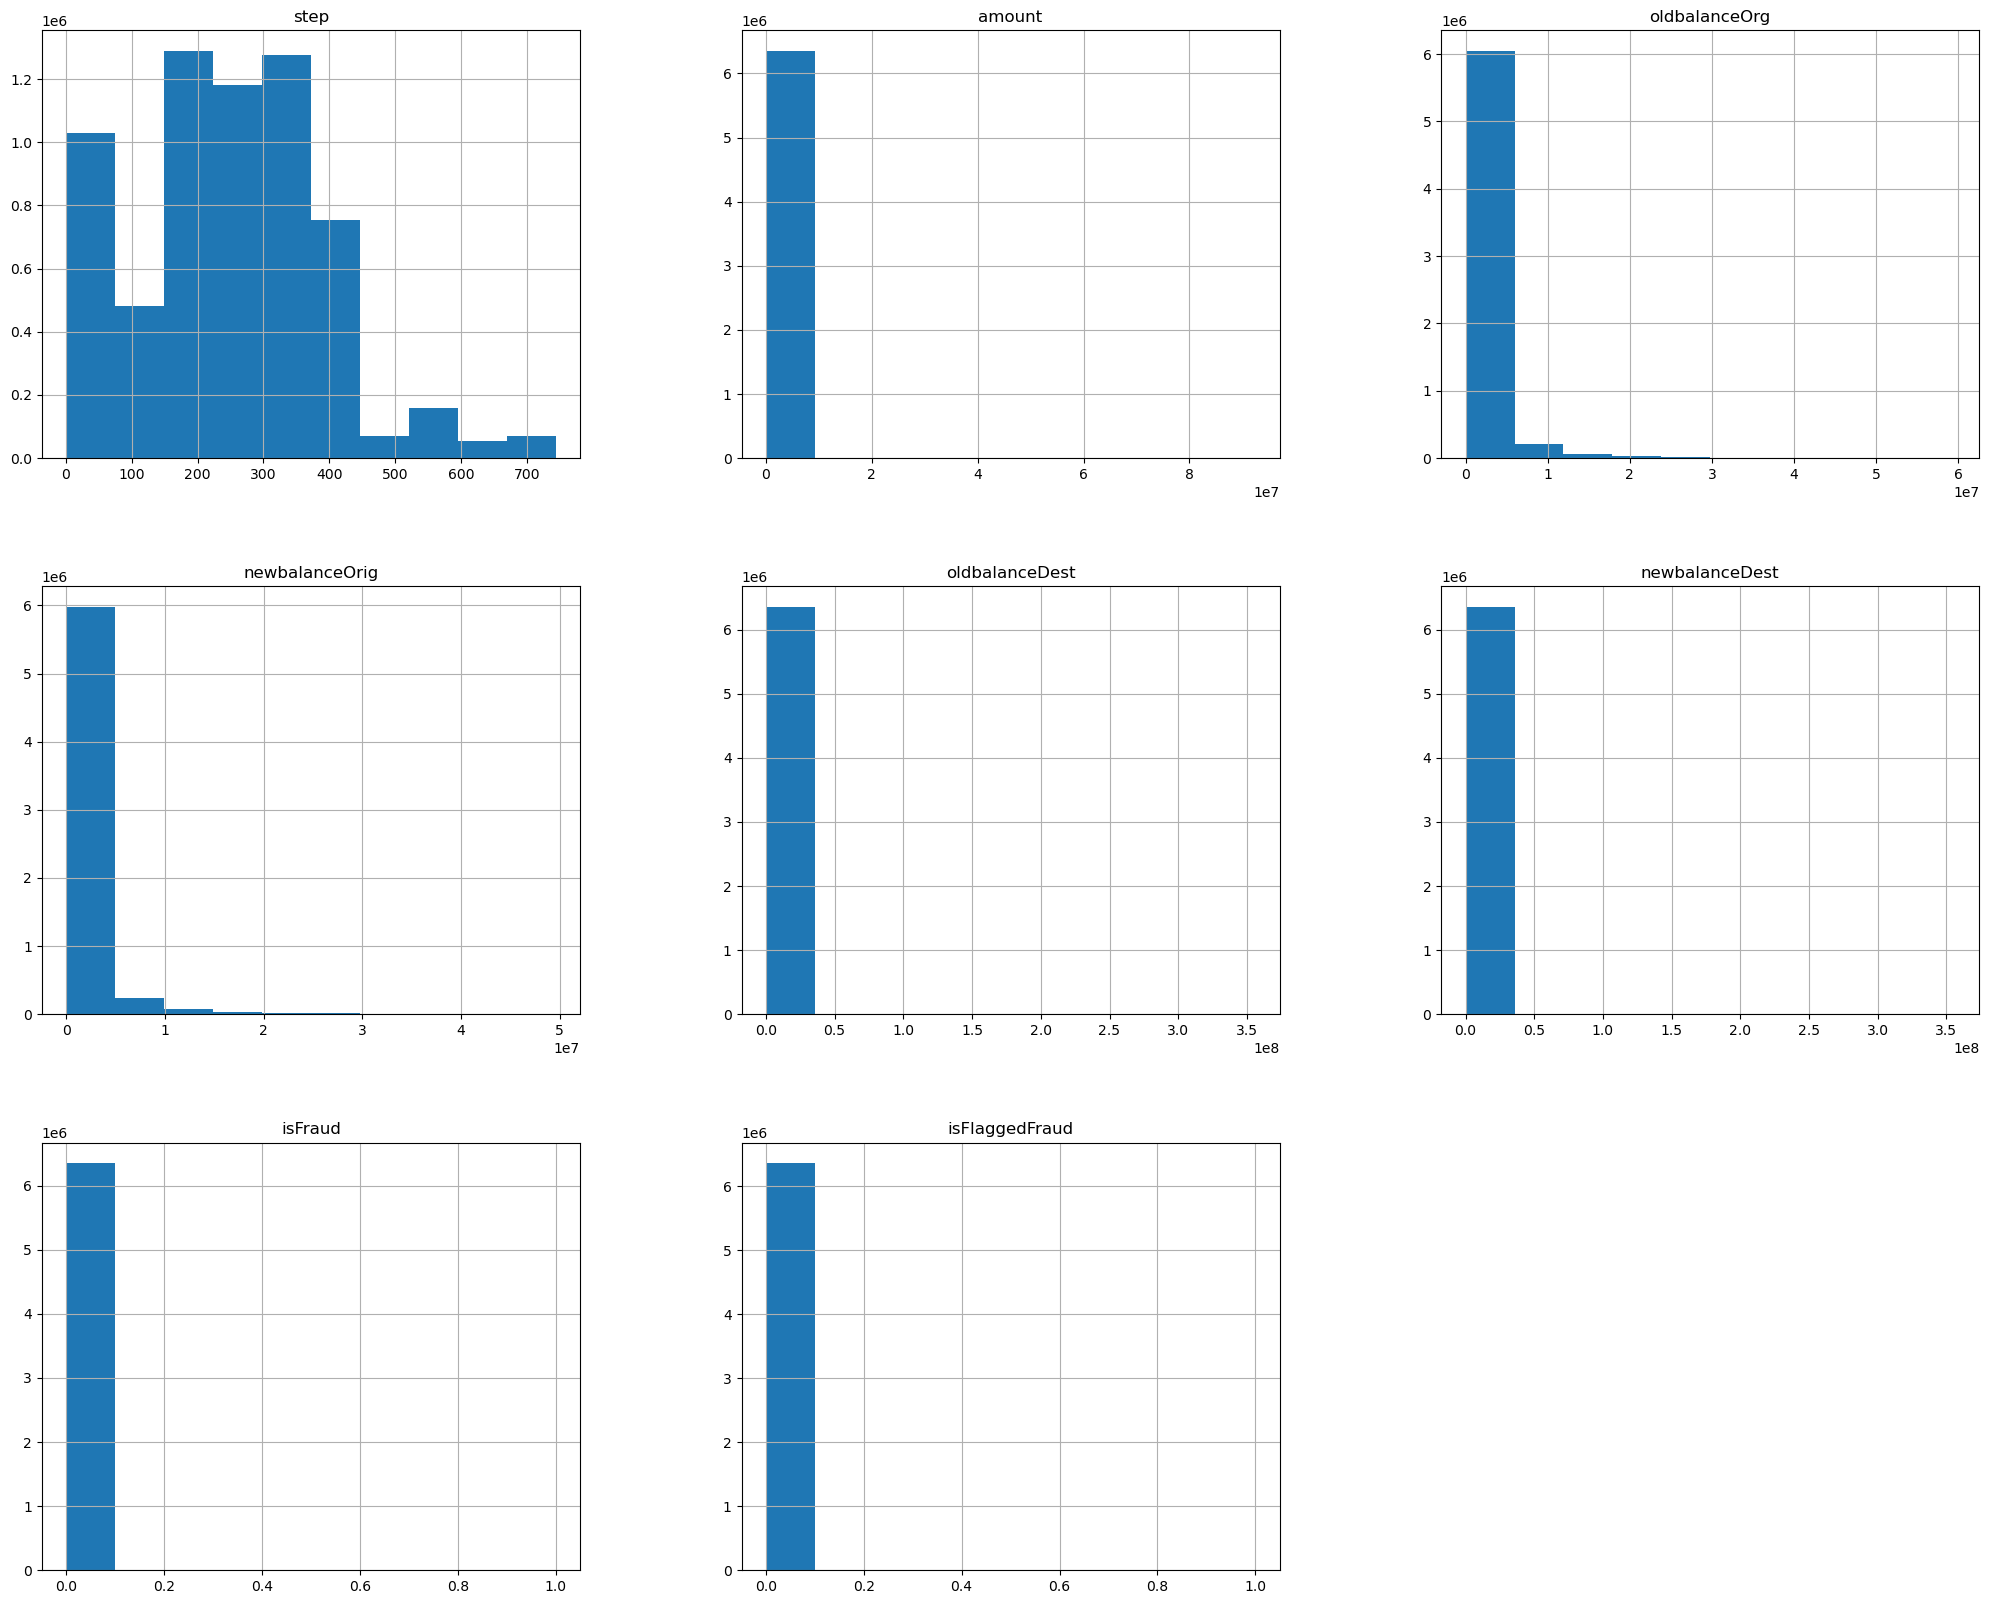

In [44]:
_,ax = plt.subplots(figsize=(25,20))
df.hist(ax=ax)
plt.show();

<font color="steelblue">
<b>Step</b> according to the doc, it's transaction dates converted to number. I'll drop it.<br>
<b>Amount</b> seems to have an outlier w/ a 92M transaction, but it is expected in fraud detection. (will invastigate if it's related to fraud)<br>
<b>Old & New balance from Origin:</b> New_balance_Orig is 0 up to 50%.<br>

<b>4. Validating features according to the documentation

According to the documentation, if the "custOrig"/"nameDest" starts with M, it's Merchant, so i'm treating the data to see it grouped and distributed between labels "C" and "M".

In [47]:
df['custOrig'] = df['nameOrig'].str[:1]
df['custDest'] = df['nameDest'].str[:1]

df.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,custOrig,custDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,C,M
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,C,M
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,C,C


In [48]:
df.groupby(['custOrig'])['amount'].count()

custOrig
C    6362620
Name: amount, dtype: int64

In [49]:
df = df.drop(columns = ['custOrig'], axis = 1)

<font color="steelblue">There's only the label 'C'.<br>
Considering it's not a relevant feature to the model, I dropped the column custOrig.</font>

Now, same process, but to the colunm "Destination customer".

In [52]:
df.groupby(['custDest','isFraud'])['amount'].count()

custDest  isFraud
C         0          4202912
          1             8213
M         0          2151495
Name: amount, dtype: int64

In [53]:
print(df.groupby(['custDest','type','isFraud'])['amount'].count())

custDest  type      isFraud
C         CASH_IN   0          1399284
          CASH_OUT  0          2233384
                    1             4116
          DEBIT     0            41432
          TRANSFER  0           528812
                    1             4097
M         PAYMENT   0          2151495
Name: amount, dtype: int64


<font color="steelblue">
<b>Observations:</b> <br>
    
+ Transactions to Merchant represent 1/3 of all transactions. <br>
+ There's no fraud for a Merchant.  
+ Type PAYMENT only exists if the transaction is for a Merchant. <br>
+ Fraud occours only when transaction Type is: CASH_OUT, TRANSFER <br>

Considering there's no Fraud (or transaction labeled as fraud) in the transaction Type: **CASH_IN, DEBIT, and PAYMENT**, I'm dropping these rows. Keeping the, won't help the model to predict fraud and will only occupy space and processing.

In [55]:
indexType = df[ (df['type'] == 'PAYMENT') ].index  # (df['type'] == 'CASH_IN') OR (df['type'] == 'DEBIT') OR 
df.drop(index = indexType, inplace=True)
indexType = df[ (df['type'] == 'CASH_IN') ].index
df.drop(index = indexType, inplace=True)
indexType = df[ (df['type'] == 'DEBIT') ].index
df.drop(index = indexType, inplace=True)

df = df.drop(columns = ['custDest'], axis = 1)

-> Investigating the column isFlaggedFraud

Documentation: <br>
**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction

In [57]:
df.shape

(2770409, 11)

In [58]:
df2 = df[(df.amount > 200000)]
df2.shape

(1197669, 11)

In [59]:
df2.groupby(['isFlaggedFraud', 'isFraud'])['amount'].count()

isFlaggedFraud  isFraud
0               0          1192198
                1             5455
1               1               16
Name: amount, dtype: int64

<font color="steelblue">

+ 43% (or 1.2M transactions) of all transactions in the dataset are above 200K, so this "isFlaggedFraud"'s rule seems innacurate.<br>
+ "isFlaggedFraud" have only 16 records and all of them are also flagged as "isFraud" <br>
+ Considering there's no new info coming from this isFlaggedFraud, and I have the same info contained in "isFraud", i'm dropping it.

In [61]:
df = df.drop(columns = ['isFlaggedFraud'], axis = 1)

-> Checking if the amount transacted matches with the difference between the Old and New Balance from Origin and Destination


In [63]:
df['balanceOrg_Diff'] = df['oldbalanceOrg'] - df['newbalanceOrig'] 
df['balanceDest_Diff'] = df['oldbalanceDest'] - df['newbalanceDest'] 
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,balanceOrg_Diff,balanceDest_Diff
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,181.0,0.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,181.0,21182.00
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,15325.0,-46430.44
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,705.0,22425.00
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,10835.0,-2712905.89


<font color="steelblue">

By the sample above, we can see few inconsistences:

+ When Type is TRANSFER (i.e: index 19, 24), both transactions amount were higher than the available balance (oldbalanceOrg).
    
+ When Type is CASH_OUT (i.e: index 15), transaction amt is 229K while Old balance is also lower (15K). Destination account increased its new balance in 46k, when shouldn't have any movement, considering it is a Cash Out transaction.
    
+ If these diffs were covered by credit given by the bank/company, it should be written in some extra column, but there's no sign of it. 

Basically, difference between Old and New balance at Origin doesn't match w/ the amount transacted. Same happens at the Destination. There's inconsistence in the Destination balance when it's Cash Out. 
    
<b>Hypotesis: </b> These differences could be divided into 2 transactions, so the sum of both of them may match it. I will check one customer to see if the payment done is divided between two payments and the sum of it is going to match with the transacted amount


In [65]:
# index 15 Cash Out

df[(df.nameOrig == 'C905080434')] 

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,balanceOrg_Diff,balanceDest_Diff
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,15325.0,-46430.44


In [66]:
# index 19 Cash Out

df[(df.nameOrig == 'C1670993182')]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,balanceOrg_Diff,balanceDest_Diff
19,1,TRANSFER,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,705.0,22425.0


<font color="steelblue">For both examples above, there's no extra transactions done by these people (nameOrig), which means there's no other transaction that cover the differences found in the balances or evidences that explain it.

-> taking a look how many unique users we have at the origin and destination.

In [69]:
print( "unique users at origin :" , f"{df['nameOrig'].nunique():,}"  , " | " , "total trx:" , f"{df['nameOrig'].count():,}" , "| Overlap:" ,  df['nameOrig'].count() / df['nameOrig'].nunique() )
print( "unique users at destin :" , f"{df['nameDest'].nunique():,}"  , " | " , "total trx:" , f"{df['nameDest'].count():,}" , "| Overlap:" ,  df['nameDest'].count() / df['nameDest'].nunique() )

unique users at origin : 2,768,630  |  total trx: 2,770,409 | Overlap: 1.0006425560656353
unique users at destin : 509,565  |  total trx: 2,770,409 | Overlap: 5.436811790448716


<br> <font color="steelblue">
    Looking at how many unique users we have at the origin and destination:

+ <font color="steelblue">1.00 of Overlap at the Origin means that this dataset has mostly users doing only one transaction. 
+ <font color="steelblue">5.43 of Overlap at the Destination means that this dataset has users receiving 5 to 6 transactions in average.
    
<font color="steelblue">The high amount of transactions being received by one user may indicate a characterist of Fraud, so let's separate it by fraud and non-fraud.

In [71]:
fraud = df[(df.isFraud == 1)]
non_fraud = df[(df.isFraud == 0)]

print( "Fraud: uniq. users at origin :" , f"{fraud['nameOrig'].nunique():,}" , " | " , "total trx:" , f"{fraud['nameOrig'].count():,}" , "| Overlap:" ,  fraud['nameOrig'].count() / fraud['nameOrig'].nunique() )
print( "Fraud: uniq. users at destin :" , f"{fraud['nameDest'].nunique():,}" , " | " , "total trx:" , f"{fraud['nameDest'].count():,}" , "| Overlap:" ,  fraud['nameDest'].count() / fraud['nameDest'].nunique() )
print(" ")

print( "Non F: uniq. users at origin :" , f"{non_fraud['nameOrig'].nunique():,}" , " | " , "total trx:" , f"{non_fraud['nameOrig'].count():,}" , "| Overlap:" ,  non_fraud['nameOrig'].count() / non_fraud['nameOrig'].nunique() )
print( "Non F: uniq. users at destin :" , f"{non_fraud['nameDest'].nunique():,}" , " | " , "total trx:" , f"{non_fraud['nameDest'].count():,}" , "| Overlap:" ,  non_fraud['nameDest'].count() / non_fraud['nameDest'].nunique() )

Fraud: uniq. users at origin : 8,213  |  total trx: 8,213 | Overlap: 1.0
Fraud: uniq. users at destin : 8,169  |  total trx: 8,213 | Overlap: 1.0053862161831313
 
Non F: uniq. users at origin : 2,760,433  |  total trx: 2,762,196 | Overlap: 1.0006386679191273
Non F: uniq. users at destin : 506,458  |  total trx: 2,762,196 | Overlap: 5.453948797333639


<font color="steelblue">
More than one transaction to the same destination occours mostly when it's **not fraud**.
<br>
    
Next, i'll finish cleaning the dataset by dropping these columns:<br>
<b>nameOrig, nameDest </b>= it's an user ID<br>
<b>Step </b>= it's an unit of time where 1 == 1 hour. There's no mark about weekday or starting time, so transforming it would require some innacurate assumption, so i'll ignore it for this task.

In [73]:
df = df.drop(columns = ['nameOrig','nameDest','step'], axis = 1)

In [74]:
df.shape

(2770409, 9)

<font color="steelblue">Treated dataset has 2,770,409 rows (before: 6,362,620), which means it reduced 56%.

## 3. Exploratory Data Analysis

**Basic Statistics comparing the share of Fraud and non fraud trx.**

<Axes: ylabel='amount'>

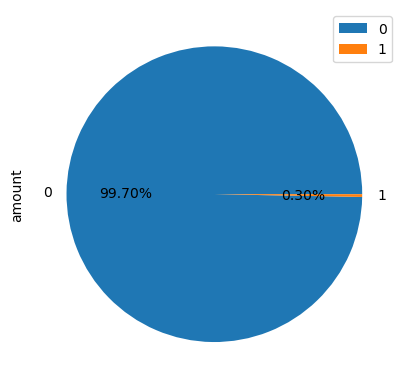

In [78]:
df.groupby(['isFraud']).count().plot( 
    kind='pie', y='amount', autopct='%1.2f%%') 

In [79]:
print(" Transaction Count | Fraud:" , f"{fraud['isFraud'].count():,}" , " & not fraud:" , f"{non_fraud['isFraud'].count():,}" )
print(" Transact. Amt AVG | Fraud:" , f"{fraud['amount'].mean().astype(int):,}" , " & not fraud:" , f"{non_fraud['amount'].mean().astype(int):,}" , " | Diff:" , fraud["amount"].mean().astype(int) - non_fraud["amount"].mean().astype(int) )
print(" ")
print(" oldbalanceOrg AVG | Fraud:" , f"{fraud['oldbalanceOrg'].mean().astype(int):,}" , " & not fraud:" , f"{non_fraud['oldbalanceOrg'].mean().astype(int):,}" , " | Diff:" , fraud["oldbalanceOrg"].mean().astype(int) - non_fraud["oldbalanceOrg"].mean().astype(int) )
print("newbalanceOrig AVG | Fraud:" , f"{fraud['newbalanceOrig'].mean().astype(int):,}" , " & not fraud:" , f"{non_fraud['newbalanceOrig'].mean().astype(int):,}" , " | Diff:" , fraud["newbalanceOrig"].mean().astype(int) - non_fraud["newbalanceOrig"].mean().astype(int) )
print(" ")
print("oldbalanceDest AVG | Fraud:" , f"{fraud['oldbalanceDest'].mean().astype(int):,}" , " & not fraud:" , f"{non_fraud['oldbalanceDest'].mean().astype(int):,}" , " | Diff:" , fraud["oldbalanceDest"].mean().astype(int) - non_fraud["oldbalanceDest"].mean().astype(int) )
print("newbalanceDest AVG | Fraud:" , f"{fraud['newbalanceDest'].mean().astype(int):,}" , " & not fraud:" , f"{non_fraud['newbalanceDest'].mean().astype(int):,}" , " | Diff:" , fraud["newbalanceDest"].mean().astype(int) - non_fraud["newbalanceDest"].mean().astype(int) )

 Transaction Count | Fraud: 8,213  & not fraud: 2,762,196
 Transact. Amt AVG | Fraud: 1,467,967  & not fraud: 314,115  | Diff: 1153852
 
 oldbalanceOrg AVG | Fraud: 1,649,667  & not fraud: 42,879  | Diff: 1606788
newbalanceOrig AVG | Fraud: 192,392  & not fraud: 15,567  | Diff: 176825
 
oldbalanceDest AVG | Fraud: 544,249  & not fraud: 1,706,998  | Diff: -1162749
newbalanceDest AVG | Fraud: 1,279,707  & not fraud: 2,052,024  | Diff: -772317


<font color="steelblue">
There's a discrepancy between amount transacted, old and new balance when it's Fraud & Not Fraud.<br>
    
1. avg amount of fraud is ~7x higher <br>
2. old balance in the origin of fraud is ~9x higher <br>
3. new balance in the origin of fraud is ~7x higher <br>
4. old balance in destination of fraud is ~5x lower <br>
5. new balance in destination of fraud is ~40% lower <br>

**Investigating the transacted amount**

<Axes: xlabel='amount'>

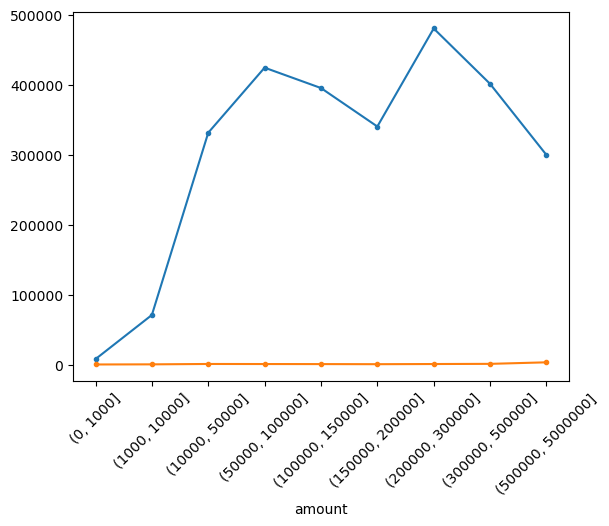

In [82]:
df_nf_plot = non_fraud.groupby(pd.cut(non_fraud['amount'], [0, 1000, 10000, 50000, 100000, 150000, 200000, 300000, 500000, 5000000]))['amount'].count()
df_nf_plot.plot( marker='.',rot=45)

df_f_plot = fraud.groupby(pd.cut(fraud['amount'], [0, 1000, 10000, 50000, 100000, 150000, 200000, 300000, 500000, 5000000]))['amount'].count()
df_f_plot.plot( marker='.',rot=45)

considering I have less fraud transactions, it's appearing flat when I plot it in the same graph with Non-fraud.
So, I'll plot it separately to compare the trend 

<Axes: xlabel='amount'>

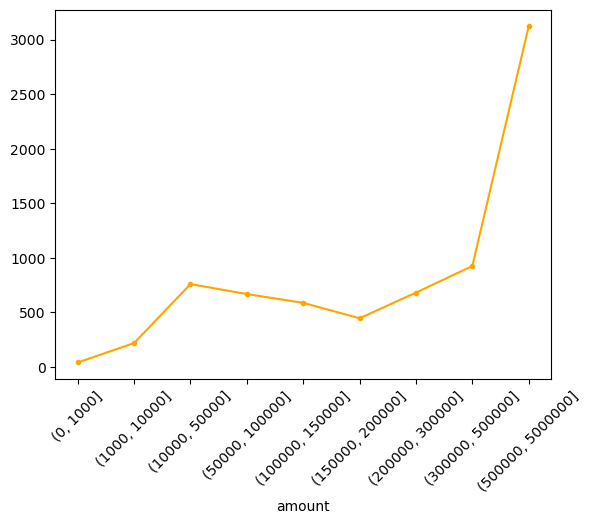

In [84]:
df_f_plot = fraud.groupby(pd.cut(fraud['amount'], [0, 1000, 10000, 50000, 100000, 150000, 200000, 300000, 500000, 5000000]))['amount'].count()
df_f_plot.plot( marker='.',rot=45, color = 'orange')

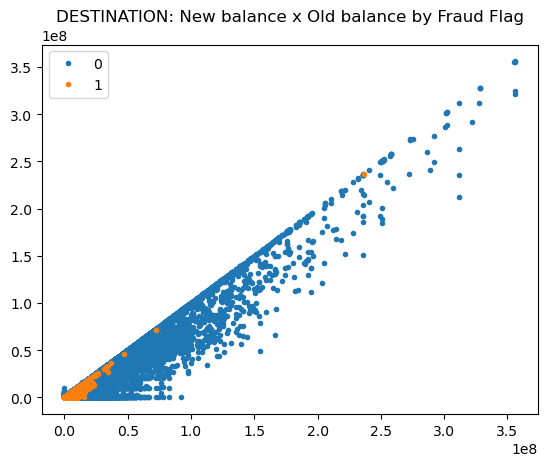

In [85]:
x = df['newbalanceDest'] 
y = df['oldbalanceDest']
c = df['isFraud']

data = pd.DataFrame({"X": x, "Y": y, "Category": c})

groups = data.groupby("Category")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker=".", linestyle="", label=name)
plt.title("DESTINATION: New balance x Old balance by Fraud Flag")
plt.legend()
plt.show()

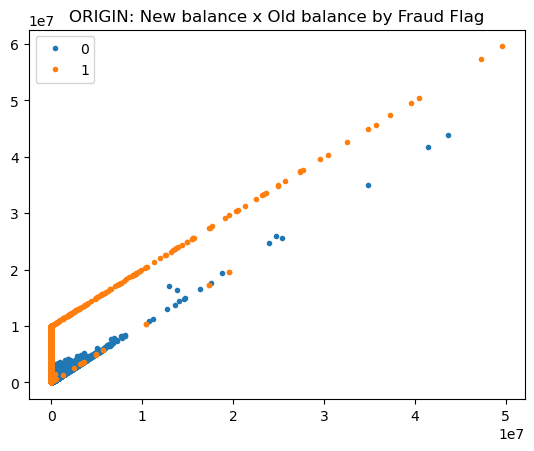

In [86]:
x = df['newbalanceOrig'] 
y = df['oldbalanceOrg']
c = df['isFraud']

data = pd.DataFrame({"X": x, "Y": y, "Category": c})

groups = data.groupby("Category")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker=".", linestyle="", label=name)
plt.title("ORIGIN: New balance x Old balance by Fraud Flag")
plt.legend()
plt.show()

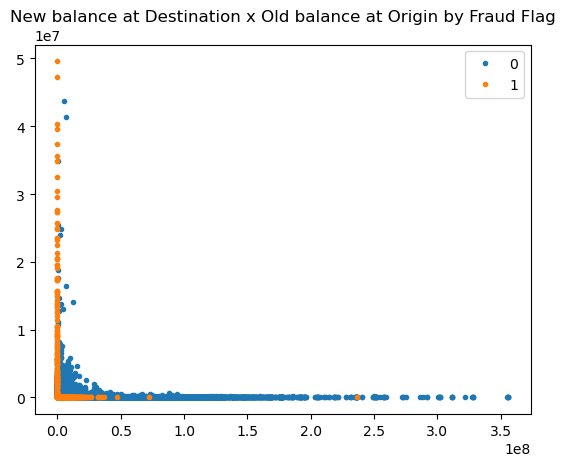

In [87]:
x = df['newbalanceDest'] 
y = df['newbalanceOrig']
c = df['isFraud']

data = pd.DataFrame({"X": x, "Y": y, "Category": c})

groups = data.groupby("Category")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker=".", linestyle="", label=name)
plt.title("New balance at Destination x Old balance at Origin by Fraud Flag")
plt.legend()
plt.show()

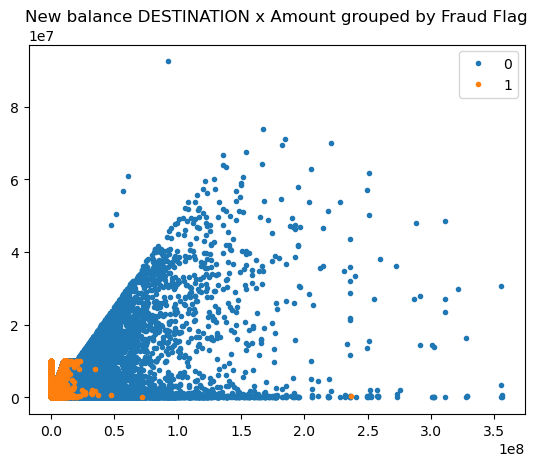

In [88]:
x = df['newbalanceDest'] 
y = df['amount']
c = df['isFraud']

data = pd.DataFrame({"X": x, "Y": y, "Category": c})

groups = data.groupby("Category")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker=".", linestyle="", label=name)
plt.title("New balance DESTINATION x Amount grouped by Fraud Flag")
plt.legend()
plt.show()

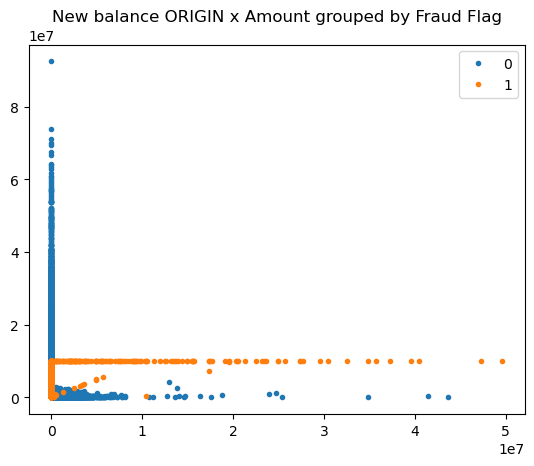

In [89]:
x = df['newbalanceOrig'] 
y = df['amount']
c = df['isFraud']

data = pd.DataFrame({"X": x, "Y": y, "Category": c})
#print(data)
# Plot data by category
groups = data.groupby("Category")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker=".", linestyle="", label=name)

plt.title("New balance ORIGIN x Amount grouped by Fraud Flag")
plt.legend()
plt.show()

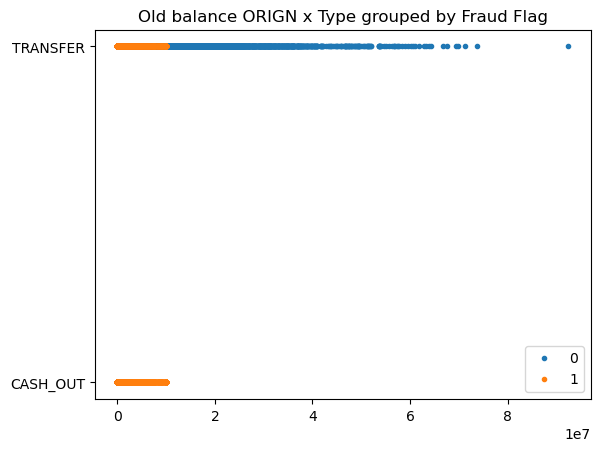

In [90]:
x = df['amount'] 
y = df['type']
c = df['isFraud']

data = pd.DataFrame({"X": x, "Y": y, "Category": c})
#print(data)
# Plot data by category
groups = data.groupby("Category")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker=".", linestyle="", label=name)

plt.title("Old balance ORIGN x Type grouped by Fraud Flag")
plt.legend()
plt.show()

<font color="steelblue">
    
By the graphs above, it's clear when it is Fraud, because the data is very segregated.
It's possible to notice it in 2 variables in particular: Amount and Old Balance at Origin (oldbalanceOrg). In the dispersion graphs, the Fraud data follows a linear pattern or it stays grouped in one point.
    
+ Considering this dataset was generated artificially, probably it was used tecniques to handle imbalanced data by creating more samples, but it ended up creating very linear and distinct fraud data.

# 4. Data modeling

<b>1.</b> Choosing the model<br>
<b>2.</b> One-hot encode<br>
<b>3.</b> Spliting dataset into training and test<br>
<b>4.</b> Resolve de unbalanced data<br>
<b>5.</b> choose models to use <br>
<b>6.</b> choose how to evaluate the model (Precision/Specificity) OR (AUC)

<b>1. Choosing the model</b>

<font color="steelblue">
Given the characteristics of this dataset, I have chosen to use a Decision Tree model. <br>
This dataset exhibits clear and distinct characteristics for Fraud and Non-Fraud, leading me to the understanding that there is no need to opt for a more sophisticated model. <br>
Even attempting to use Random Forest may not yield significantly better results, as it would divide the process into many trees, consuming more processing power and time than necessary for such a straightforward case.

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV, StratifiedKFold

<b>2.</b> One-hot encode<br>

Converting categorial features in columns with numerical flags

In [97]:
one_hot = pd.get_dummies(df['type'])
df = df.drop('type',axis = 1)
df = df.join(one_hot)

df.head(3)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceOrg_Diff,balanceDest_Diff,CASH_OUT,TRANSFER
2,181.00,181.0,0.0,0.0,0.00,1,181.0,0.00,False,True
3,181.00,181.0,0.0,21182.0,0.00,1,181.0,21182.00,True,False
15,229133.94,15325.0,0.0,5083.0,51513.44,0,15325.0,-46430.44,True,False


<b>3.</b> Spliting dataset into training and test

In [99]:
# separating the data into variables X and y:
columns = df.iloc[:, [0,1,2,3,4,6,7,8,9]].columns # slicing and retrieving the columns by interval to ignore the isFraud(column 5)

X_model = df[columns]
y_model = df['isFraud']

Train test split: separating to the ratio of 80:20

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42, shuffle = True)

In [102]:
print('Total records in the training dataset is', f"{X_train.shape[0]:,}")
print('Fraud in the test dataset is            ', f"{y_test.sum():,}" , " representing ", (y_test.sum() / X_train.shape[0]) ) 
print(' ')
print('Total records in the test dataset is    ', f"{X_test.shape[0]:,}")
print('Fraud in the training dataset is        ', f"{y_train.sum():,}" , " representing ", (y_train.sum() / X_train.shape[0]) ) 

Total records in the training dataset is 2,216,327
Fraud in the test dataset is             1,646  representing  0.0007426701926204933
 
Total records in the test dataset is     554,082
Fraud in the training dataset is         6,567  representing  0.0029630104221985295


**Decision tree**

In [104]:
dt = DecisionTreeClassifier(random_state=1)
dt_model = dt.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)

In [105]:
print(classification_report(y_test, dt_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.90      0.89      0.89      1646

    accuracy                           1.00    554082
   macro avg       0.95      0.94      0.95    554082
weighted avg       1.00      1.00      1.00    554082



<Axes: >

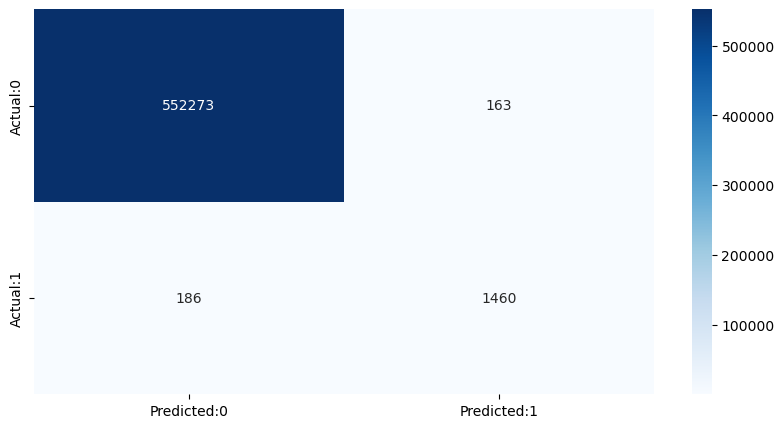

In [106]:
cm = confusion_matrix(y_test, dt_y_pred)
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

plt.figure(figsize = (10,5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')

<font color="steelblue"> In this first attempt, decision tree classified "Fraud" (value 1) with 90% of precision. "Non Fraud" (value 0) overfitted, having 100% in all parameters.

**Adding cross-validation**

In [113]:
from sklearn.model_selection import cross_val_score

In [115]:
for i in range(3, 10):
    scores = cross_val_score(dt, X_model, y_model, cv=i, scoring='precision')
    print((i), ' -> ', str(np.mean(scores)), ' - min: ', str(scores.min()), ' - max: ', str(scores.max()))

3  ->  0.8811926364688737  - min:  0.8476190476190476  - max:  0.8998883513211761
4  ->  0.8936467052844397  - min:  0.8513708513708513  - max:  0.9100346020761245
5  ->  0.8962185466568731  - min:  0.8519402985074627  - max:  0.9176980198019802
6  ->  0.8981525661079769  - min:  0.8344086021505376  - max:  0.9130111524163569
7  ->  0.9006256624471457  - min:  0.8228476821192053  - max:  0.923278116826504
8  ->  0.905984191240403  - min:  0.8279158699808795  - max:  0.9310344827586207
9  ->  0.9034435568057256  - min:  0.8159574468085107  - max:  0.9260969976905312


** needs to adjust and conclude the cross-validation 

# 5. Conclusion

1. This is an artificial dataset of fraud.<br>
2. Fraudulent transactions only occur in transfers and cash withdrawals.<br>
3. There are six features available to use for fraud prediction.<br>
4. However, four out of six do not match their corresponding cash inflow and outflow values. Although these four labels are not reliable from a rule perspective, it was decided not to drop them; otherwise, the model would end up with only two features.<br>
5. Outliers were detected in the amount and the balances of both new and old accounts.<br>
6. Transaction types Cash_In, Debit, and Payment had no fraudulent data. Dropping these rows reduced the dataset by 56%.<br>
7. Exploratory data analysis showed a pattern in fraud cases. It is evident from the graphs that this dataset was generated by some k-means model, reproducing fake fraud data linearly and creating two extreme clusters.<br>
8. Based on the exploratory data analysis, it was decided to use a decision tree model.<br>
9. With the decision tree, the model achieved 90% of accuracy predicting fraud but overfitted the non-fraud data, reaching 100% in all parameters, without attempting to boost or improve the model.